Root Mean Squared Error (RMSE): 543.8319719959562


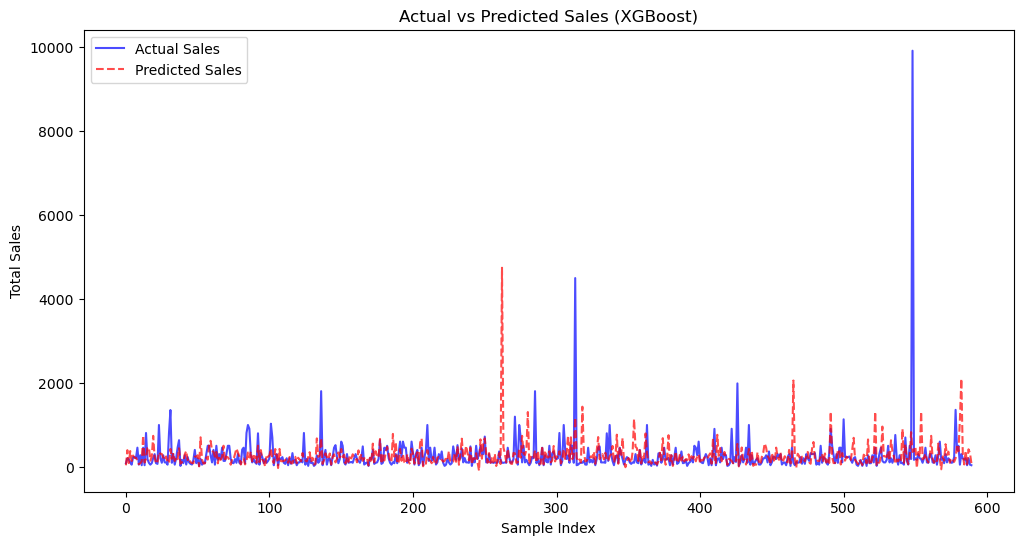

In [20]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load and preprocess data

sales_data = pd.read_csv("cleaned_sales.csv")
sales_data['date'] = pd.to_datetime(sales_data['date'])
sales_data_grouped = sales_data.groupby(['date', 'product_name', 'city'], as_index=False)['total_sales'].sum()

# Extract time-based features
sales_data_grouped['day'] = sales_data_grouped['date'].dt.day
sales_data_grouped['week'] = sales_data_grouped['date'].dt.isocalendar().week
sales_data_grouped['month'] = sales_data_grouped['date'].dt.month
sales_data_grouped['year'] = sales_data_grouped['date'].dt.year

# Encode categorical variables (product_name and city)
sales_data_encoded = pd.get_dummies(sales_data_grouped, columns=['product_name', 'city'])

# Define features and target
X = sales_data_encoded.drop(['total_sales', 'date'], axis=1)
y = sales_data_encoded['total_sales']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set and calculate RMSE
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

# Plot actual vs predicted sales
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Sales', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Sales', color='red', linestyle='--', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Total Sales')
plt.title('Actual vs Predicted Sales (XGBoost)')
plt.legend()
plt.show()


In [21]:
import datetime

# Get the last date in the dataset
last_date = sales_data_grouped['date'].max()

# Generate next 10 days
forecast_dates = [last_date + datetime.timedelta(days=i) for i in range(1, 11)]

# Prepare a DataFrame for future dates with feature columns
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'day': [d.day for d in forecast_dates],
    'week': [d.isocalendar()[1] for d in forecast_dates],
    'month': [d.month for d in forecast_dates],
    'year': [d.year for d in forecast_dates],
})

# Add dummy variables for each product and city (adjust to your dataset’s unique products and cities)
product_names = sales_data_encoded.filter(like='product_name').columns
cities = sales_data_encoded.filter(like='city').columns

# Repeat for each product and city combination
forecast_data = pd.DataFrame()
for product in product_names:
    for city in cities:
        temp_df = forecast_df.copy()
        
        # Initialize all product_name and city columns as 0
        for col in product_names:
            temp_df[col] = 0
        for col in cities:
            temp_df[col] = 0

        # Set current product and city to 1 for encoding
        temp_df[product] = 1
        temp_df[city] = 1

        # Append to forecast data
        forecast_data = pd.concat([forecast_data, temp_df])

# Drop 'date' as it's not a feature in the model
forecast_data = forecast_data.drop(['date'], axis=1)

# Make predictions using the trained model
forecast_predictions = xgb_model.predict(forecast_data)

# Combine predictions with corresponding dates, products, and cities
forecast_results = forecast_data.copy()
forecast_results['total_sales_forecast'] = forecast_predictions
forecast_results['date'] = forecast_df['date'].repeat(len(product_names) * len(cities)).values
forecast_results['product_name'] = [p.split('_')[-1] for p in product_names] * len(cities) * 10
forecast_results['city'] = [c.split('_')[-1] for c in cities] * len(product_names) * 10

# Display forecast results for the next 10 days
forecast_results[['date', 'product_name', 'city', 'total_sales_forecast']]


,date,product_name,city,total_sales_forecast
0,2023-01-18 09:24:09,product x,Cairo,362.994812
1,2023-01-18 09:24:09,product y,Giza,659.135010
2,2023-01-18 09:24:09,product z,North,2105.603027
3,2023-01-18 09:24:09,product x,Cairo,197.904648
4,2023-01-18 09:24:09,product y,Giza,229.581223
...,...,...,...,...
5,2023-01-27 09:24:09,product y,Giza,82.391846
6,2023-01-27 09:24:09,product z,North,139.145065
7,2023-01-27 09:24:09,product x,Cairo,260.327820
8,2023-01-27 09:24:09,product y,Giza,96.635689


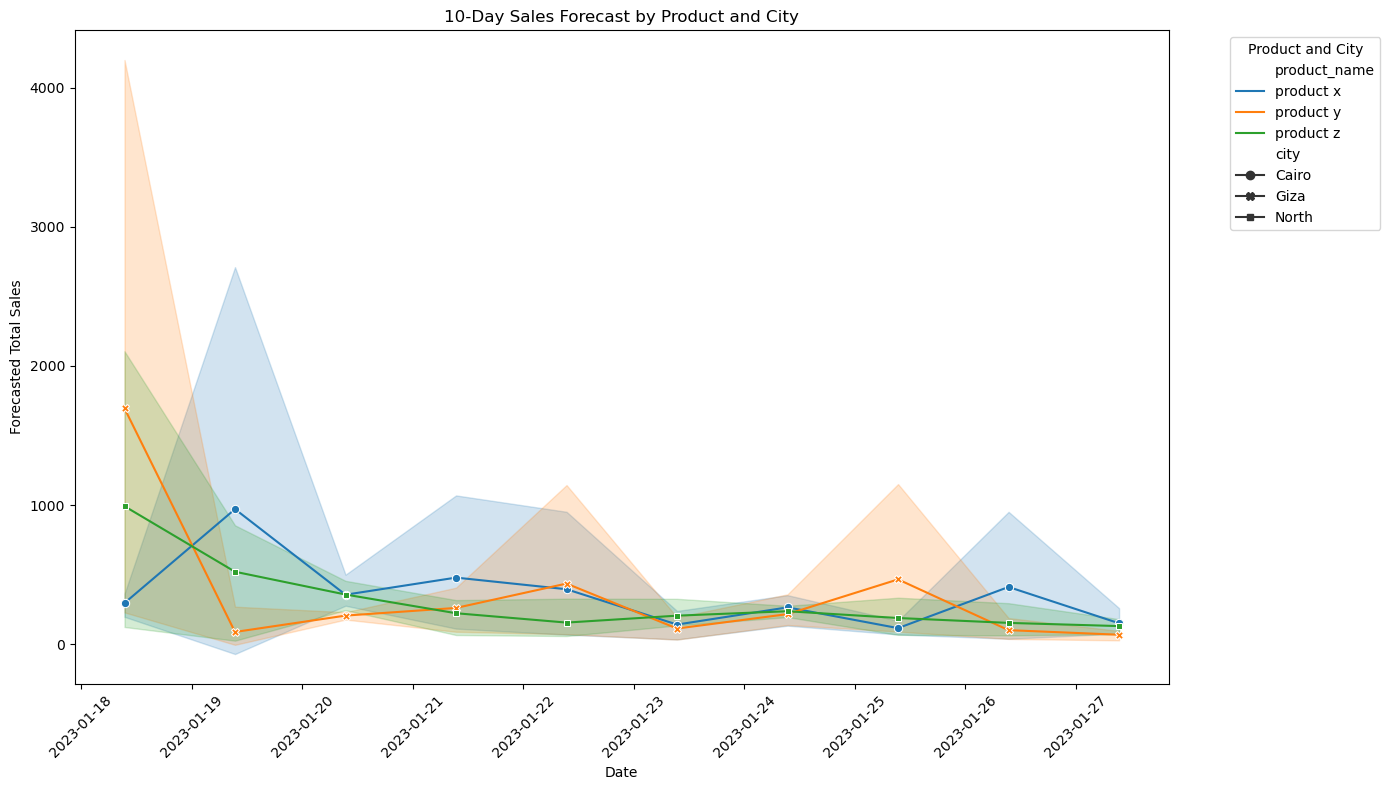

In [23]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Get the last date in the dataset
last_date = sales_data_grouped['date'].max()

# Generate the next 10 days
forecast_dates = [last_date + datetime.timedelta(days=i) for i in range(1, 11)]

# Prepare a DataFrame for future dates with feature columns
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'day': [d.day for d in forecast_dates],
    'week': [d.isocalendar()[1] for d in forecast_dates],
    'month': [d.month for d in forecast_dates],
    'year': [d.year for d in forecast_dates],
})

# Add dummy variables for each product and city (adjust to your dataset’s unique products and cities)
product_names = sales_data_encoded.filter(like='product_name').columns
cities = sales_data_encoded.filter(like='city').columns

# Create a DataFrame to store all forecast results
forecast_data = pd.DataFrame()

# Repeat for each product and city combination
for product in product_names:
    for city in cities:
        temp_df = forecast_df.copy()
        
        # Initialize all product_name and city columns as 0
        for col in product_names:
            temp_df[col] = 0
        for col in cities:
            temp_df[col] = 0

        # Set current product and city to 1 for encoding
        temp_df[product] = 1
        temp_df[city] = 1

        # Append to forecast data
        forecast_data = pd.concat([forecast_data, temp_df])

# Drop 'date' as it's not a feature in the model
forecast_data = forecast_data.drop(['date'], axis=1)

# Make predictions using the trained model
forecast_predictions = xgb_model.predict(forecast_data)

# Combine predictions with corresponding dates, products, and cities
forecast_results = forecast_data.copy()
forecast_results['total_sales_forecast'] = forecast_predictions
forecast_results['date'] = forecast_df['date'].repeat(len(product_names) * len(cities)).values
forecast_results['product_name'] = [p.split('_')[-1] for p in product_names] * len(cities) * 10
forecast_results['city'] = [c.split('_')[-1] for c in cities] * len(product_names) * 10

# Ensure there are no duplicate labels by resetting the index
forecast_results = forecast_results.reset_index(drop=True)

# Plot forecasted sales for each product in each city
plt.figure(figsize=(14, 8))
sns.lineplot(data=forecast_results, x='date', y='total_sales_forecast', hue='product_name', style='city', markers=True, dashes=False)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Forecasted Total Sales')
plt.title('10-Day Sales Forecast by Product and City')
plt.legend(title='Product and City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
